In [ ]:
!pip install alpha_vantage

     |████████████████████████████████| 1.3 MB 30.1 MB/s 
     |████████████████████████████████| 294 kB 47.7 MB/s 
     |████████████████████████████████| 142 kB 54.3 MB/s 


**Stuff to try based on possible problems**
1. The problem is that there is not enough data for LSTM
  - change the test-training test split from 0.8 to 0.9
  - add the rest of the data instead of just using the first 1000 days
  - (UNFIXABLE) There are other metrics that are needed as inputs
2. The problem is that the parameters are arbitrary and not optimized
  - change the number of days being used for prediction (i.e. change num_days_used)
  - change the parameters on the layers
3. The problem is that the layers being used are too arbitrary
  - add/subtract layers based on research
  - change the layer types
4. The problem is that the scaling is off
  - Check out the scaling factor problem

**PRIORITY #1: GET MULTIOUTPUT WORKING / FIGURE OUT BACKPROP**

**GAMEPLAN:** For the next sprint, spend around 1.5 hours on trying out the different solutions outlined, but afterwards move on to adapting the current code to accomodate multiple outputs. More specifically, change the model so that there are now multiple branches for the output.





In [ ]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from alpha_vantage.timeseries import TimeSeries

**Getting Apple's stock price history using AlphaVantage**



In [ ]:
# Configuring AlphaVantage stuff

# Storing my API key
api_key = open('AlphaVantage_API_key.txt').read()

# Creating a function to save datasets into csv's
def save_dataset(symbol):

    ts = TimeSeries(api_key, output_format='pandas')
    data, meta_data = ts.get_daily_adjusted(symbol, outputsize='full')
    data.to_csv(f'./{symbol}_daily_adjusted.csv')


In [ ]:
# Downloading AAPL's stock price history 
save_dataset('AAPL')
df = pd.read_csv('/content/AAPL_daily_adjusted.csv')

**Preprocessing Apple's data**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 999 to 0
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1000 non-null   datetime64[ns]
 1   1. open               1000 non-null   float64       
 2   2. high               1000 non-null   float64       
 3   3. low                1000 non-null   float64       
 4   4. close              1000 non-null   float64       
 5   5. adjusted close     1000 non-null   float64       
 6   6. volume             1000 non-null   float64       
 7   7. dividend amount    1000 non-null   float64       
 8   8. split coefficient  1000 non-null   float64       
 9   old close             1000 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 78.3 KB


,date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,old close
999,2017-08-03,37.373941,37.412017,36.890852,37.021738,37.021738,26000738.0,0.0,1.0,155.570000
998,2017-08-04,37.140725,37.457232,37.050295,37.216877,37.216877,20349532.0,0.0,1.0,156.390000
997,2017-08-07,37.376320,37.818954,37.283534,37.792776,37.792776,21870321.0,0.0,1.0,158.810000
996,2017-08-08,37.742802,38.511460,37.664270,38.095004,38.095004,35775675.0,0.0,1.0,160.080000
995,2017-08-09,37.899865,38.378194,37.864169,38.328219,38.328219,25640394.0,0.0,1.0,161.059998
...,...,...,...,...,...,...,...,...,...,...
4,2021-07-19,143.750000,144.070000,141.670000,142.450000,142.450000,121434571.0,0.0,1.0,142.450000
3,2021-07-20,143.460000,147.099700,142.960000,146.150000,146.150000,96350036.0,0.0,1.0,146.150000
2,2021-07-21,145.530000,146.130000,144.630000,145.400000,145.400000,74993460.0,0.0,1.0,145.400000
1,2021-07-22,145.935000,148.195000,145.810000,146.800000,146.800000,77338156.0,0.0,1.0,146.800000


None

,1. open,2. high,3. low,5. adjusted close,6. volume
999,37.373941,37.412017,36.890852,37.021738,26000738.0
998,37.140725,37.457232,37.050295,37.216877,20349532.0
997,37.376320,37.818954,37.283534,37.792776,21870321.0
996,37.742802,38.511460,37.664270,38.095004,35775675.0
995,37.899865,38.378194,37.864169,38.328219,25640394.0
...,...,...,...,...,...
4,143.750000,144.070000,141.670000,142.450000,121434571.0
3,143.460000,147.099700,142.960000,146.150000,96350036.0
2,145.530000,146.130000,144.630000,145.400000,74993460.0
1,145.935000,148.195000,145.810000,146.800000,77338156.0


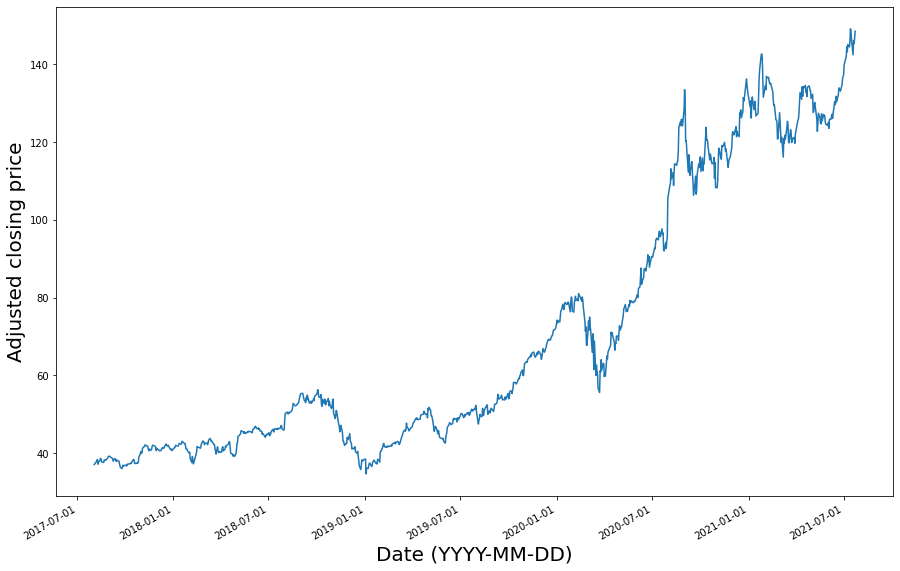

In [ ]:
# Creating a dataframe for data for the past 1000 days (last day is on 05/28/2021)
# that's been adjusted based on the values from close / adjusted close. 
# NOTE: 'Adjusted close' has a specific meaning, which causes the values
# from close / adjusted close to not necessarily reflect the stock split.
# For example, this value can be 4.202 sometimes even if the stock split is 4:1.
# Thus, the data may not be accurate but can still be used for a preliminary investigation.

df_1000 = df[:1000].iloc[::-1]
adjustment_factor = df_1000['4. close'] / df_1000['5. adjusted close']
df_1000['1. open'] = df_1000['1. open'] / adjustment_factor
df_1000['2. high'] = df_1000['2. high'] / adjustment_factor
df_1000['3. low'] = df_1000['3. low'] / adjustment_factor
df_1000['old close'] = df_1000['4. close']
df_1000['4. close'] = df_1000['4. close'] / adjustment_factor

df_1000['date'] = pd.to_datetime(df_1000['date'], yearfirst=True, format='%Y-%m-%d')
display(df_1000, df_1000.info())

# Plotting the adjusted close vs. time
# _______________________________________________
fig = plt.figure(figsize=(15, 10))
plt.xlabel('Date (YYYY-MM-DD)', fontsize=20)
plt.ylabel('Adjusted closing price', fontsize=20)

dates = df_1000['date']
y_prices = df_1000['5. adjusted close']

ax = plt.gca()
formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)

plt.plot(dates, y_prices)
ax.xaxis_date()
fig.autofmt_xdate()
# _______________________________________________

# Creating a new dataframe with just the four inputs I want
df_1000 = df_1000[['1. open', '2. high', '3. low', '5. adjusted close', '6. volume']]

display(df_1000)

In [ ]:
from sklearn import preprocessing 
# Creating a variable to control how many days in the past to use as data for a single prediction
num_days_used = 5

# Normalising data using MinMax
# df_1000 turns into a 2D-array, now named arr_1000
minmax_scaler = preprocessing.MinMaxScaler()
arr_1000 = minmax_scaler.fit_transform(df_1000)

display(arr_1000)

array([[0.02039774, 0.01697247, 0.0205819 , 0.02106502, 0.04556861],
       [0.01835549, 0.01736726, 0.02199144, 0.02276868, 0.02797704],
       [0.02041858, 0.02052552, 0.02405336, 0.02779656, 0.03271108],
       ...,
       [0.96751182, 0.96621028, 0.97303684, 0.96726065, 0.19807745],
       [0.97105838, 0.98424019, 0.98346849, 0.97948334, 0.20537623],
       [0.9852008 , 0.98880399, 0.99328131, 0.99484901, 0.18703902]])

In [ ]:
# Storing the number of data points in the array
num_data = len(arr_1000)

# Creating a numpy array that contains the past num_days_used days' open, high, low, close, and volume
# For example, when num_days_used = 30, each element in the list contains those values for the previous 30 days
# This is equivalent to the input / X-values to be used 
data_used = np.array([arr_1000[i : i + num_days_used].copy() for i in range(num_data - num_days_used)])

# Creating a numpy array that contains the value(s) to predict
# Currently, trying to fit the 4 outputs
data_to_predict = np.array(arr_1000[(num_days_used):, :4])
# data_to_predict = np.expand_dims(data_to_predict, -1)

# Storing the scaler object for prediction later
# NOTE: I'm concerned that this min_max scaler will be inaccurate because of the
# scale's dependence on the max value of the training set
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(df_1000[['1. open', '2. high', '3. low', '5. adjusted close']].to_numpy()[num_days_used:])

# data_used.shape
# data_to_predict.shape[0]
# display(data_to_predict)
display(arr_1000.shape, data_used.shape, data_to_predict.shape)

(1000, 5)

(995, 5, 5)

(995, 4)

In [ ]:
from numpy import random
np.random.seed(18)
# Fraction of data that's used as the training set
train_split = 0.8
data_size = data_used.shape[0]
train_size = int(data_size * train_split)
test_size = data_size - train_size
random_indices = np.random.choice(data_size, size = train_size, replace=False)

# Creating a mask / an array of booleans where the random_indices are false
# Acts as a filter to create the test set based on which indices were selected
# to be part of the training set 
mask = np.ones(data_used.shape[0], dtype=bool)
mask[random_indices] = False

# Splitting the dataset up into train and test sets
X_train = data_used[random_indices, :, :]
y_train = data_to_predict[random_indices, :]
X_test = data_used[mask, :, :]
y_test = data_to_predict[mask, :]

unscaled_y_test = df_1000[['1. open', '2. high', '3. low', '5. adjusted close']].to_numpy()[(num_days_used):][mask, :]

display(X_train.shape, y_train.shape, X_test.shape, y_test.shape, unscaled_y_test.shape)
# display(unscaled_y_test, y_normaliser.inverse_transform(y_test))
# display(mask.shape, data_used.shape, data_used[random_indices, :, :].shape, data_used[mask, :, :].shape)

# NOTE: inverse_transforming the normalised y_test returns similar values to the original
# adjusted closing price, but are NOT EXACT

(796, 5, 5)

(796, 4)

(199, 5, 5)

(199, 4)

(199, 4)

**Building the model**

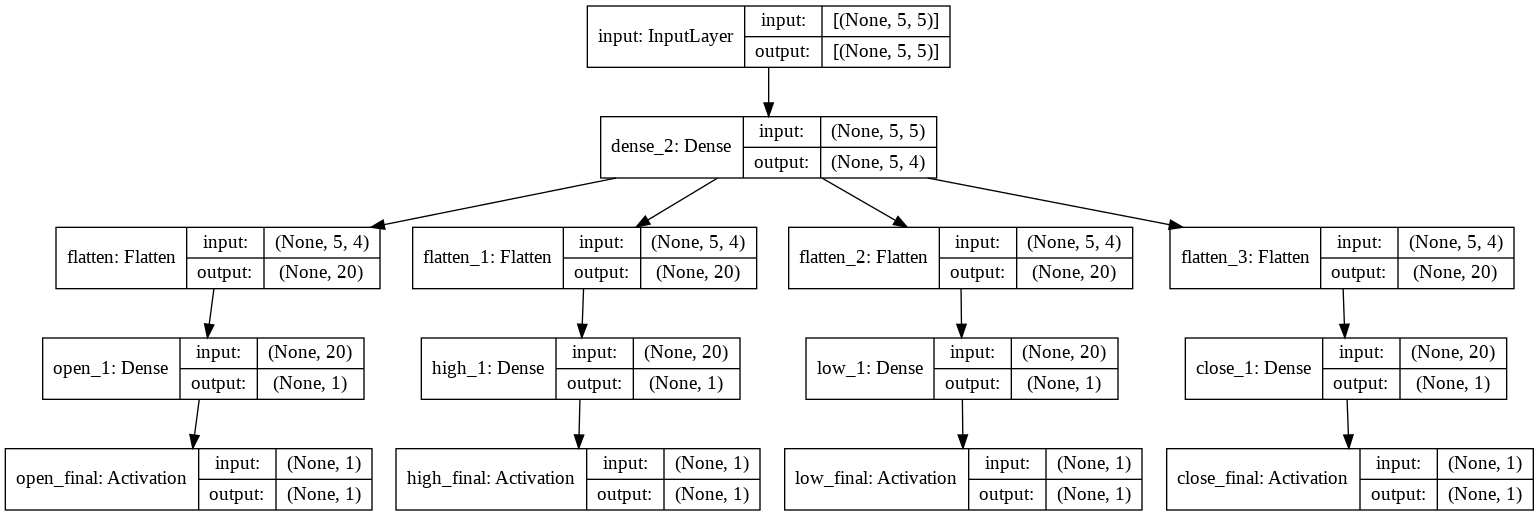

In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Flatten
from keras import optimizers

# Creating the input layer, whose shape is (num_days_used, 5) because it is
# the open, high, low, close, volume for the past num_days_used days 
input = Input(shape=(num_days_used, 5), name = 'input')

# Adding the rest of the layers
# NOTE: All are currently being added arbitrarily. Look at keras.layers for more
# information on each type, but a quick summary is provided. Also, for LSTM
# and Dropout, powers of 2 are used for units as it *may* result in faster computations

# Dense is a regular, fully connected layer
# x = Dense(32, activation = "tanh", name='dense_0')(input)
# x = Dense(16, activation = "tanh", name='dense_1')(x)
x = Dense(4, activation = "tanh", name='dense_2')(input)

# Branching out
# output1 = Dense(2, activation = "tanh", name='open_0')(x)
output1 = Flatten()(x)
output1 = Dense(1, activation = "tanh", name='open_1')(output1)
output1 = Activation('linear', name='open_final')(output1)

# output2 = Dense(2, activation = "tanh", name='high_0')(x)
output2 = Flatten()(x)
output2 = Dense(1, activation = "tanh", name='high_1')(output2)
output2 = Activation('linear', name='high_final')(output2)

# output3 = Dense(2, activation = "tanh", name='low_0')(x)
output3 = Flatten()(x)
output3 = Dense(1, activation = "tanh", name='low_1')(output3)
output3 = Activation('linear', name='low_final')(output3)

# output4 = Dense(2, activation = "tanh", name='close_0')(x)
output4 = Flatten()(x)
output4 = Dense(1, activation = "tanh", name='close_1')(output4)
output4 = Activation('linear', name='close_final')(output4)

model = Model(inputs = input, outputs = [output1, output2, output3, output4])

# Choosing Adam as the optimizer
# Adam is an optimizer of hyperparameters
adam = optimizers.Adam(learning_rate=0.001)

# model.compile is where you define the type of optimizer, loss, etc. 
# that you want to use. Here, we use Adam and MSE
model.compile(optimizer=adam, loss='mse')

# Displaying the structure of the final model
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# import keras
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Flatten
# from keras import optimizers

# # Creating the input layer, whose shape is (num_days_used, 5) because it is
# # the open, high, low, close, volume for the past num_days_used days 
# input = Input(shape=(num_days_used, 5), name = 'input')

# # Adding the rest of the layers
# # NOTE: All are currently being added arbitrarily. Look at keras.layers for more
# # information on each type, but a quick summary is provided. Also, for LSTM
# # and Dropout, powers of 2 are used for units as it *may* result in faster computations

# # Dense is a regular, fully connected layer


# # Branching out
# output1 = Dense(32, activation = "tanh", name='open_0')(input)
# output1 = Dense(16, activation = "tanh", name='open_1')(output1)
# output1 = Dense(4, activation = "tanh", name='open_2')(output1)
# output1 = Dense(2, activation = "tanh", name='open_3')(output1)
# output1 = Flatten()(output1)
# output1 = Dense(1, activation = "tanh", name='open_4')(output1)
# output1 = Activation('linear', name='open_final')(output1)

# output2 = Dense(32, activation = "tanh", name='high_0')(input)
# output2 = Dense(16, activation = "tanh", name='high_1')(output2)
# output2 = Dense(4, activation = "tanh", name='high_2')(output2)
# output2 = Dense(2, activation = "tanh", name='high_3')(output2)
# output2 = Flatten()(output2)
# output2 = Dense(1, activation = "tanh", name='high_4')(output2)
# output2 = Activation('linear', name='high_final')(output2)

# output3 = Dense(32, activation = "tanh", name='low_0')(input)
# output3 = Dense(16, activation = "tanh", name='low_1')(output3)
# output3 = Dense(4, activation = "tanh", name='low_2')(output3)
# output3 = Dense(2, activation = "tanh", name='low_3')(output3)
# output3 = Flatten()(output3)
# output3 = Dense(1, activation = "tanh", name='low_4')(output3)
# output3 = Activation('linear', name='low_final')(output3)

# output4 = Dense(32, activation = "tanh", name='close_0')(input)
# output4 = Dense(16, activation = "tanh", name='close_1')(output4)
# output4 = Dense(4, activation = "tanh", name='close_2')(output4)
# output4 = Dense(2, activation = "tanh", name='close_3')(output4)
# output4 = Flatten()(output4)
# output4 = Dense(1, activation = "tanh", name='close_4')(output4)
# output4 = Activation('linear', name='close_final')(output4)

# model = Model(inputs = input, outputs = [output1, output2, output3, output4])

# # Choosing Adam as the optimizer
# # Adam is an optimizer of hyperparameters
# adam = optimizers.Adam(learning_rate=0.001)

# # model.compile is where you define the type of optimizer, loss, etc. 
# # that you want to use. Here, we use Adam and MSE
# model.compile(optimizer=adam, loss='mse')

# # Displaying the structure of the final model
# from keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes=True)

**Fitting the model and doing an initial evaluation on the normalized data**

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.2)
evaluation = model.evaluate(X_test, y_test)
print(evaluation)

Epoch 1/50
20/20 [==============================] - 16s 51ms/step - loss: 1.0221 - open_final_loss: 0.0072 - high_final_loss: 0.5865 - low_final_loss: 0.1586 - close_final_loss: 0.2698 - val_loss: 0.7294 - val_open_final_loss: 0.0054 - val_high_final_loss: 0.4578 - val_low_final_loss: 0.1157 - val_close_final_loss: 0.1505
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6432 - open_final_loss: 0.0045 - high_final_loss: 0.4163 - low_final_loss: 0.1007 - close_final_loss: 0.1217 - val_loss: 0.3947 - val_open_final_loss: 0.0039 - val_high_final_loss: 0.2668 - val_low_final_loss: 0.0662 - val_close_final_loss: 0.0578
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.3456 - open_final_loss: 0.0041 - high_final_loss: 0.2358 - low_final_loss: 0.0580 - close_final_loss: 0.0477 - val_loss: 0.1935 - val_open_final_loss: 0.0036 - val_high_final_loss: 0.1284 - val_low_final_loss: 0.0340 - val_close_final_loss: 0.0276
Epoch 4/50
20/20 [==============

**True evaluation by inversely scaling normalized predictions**

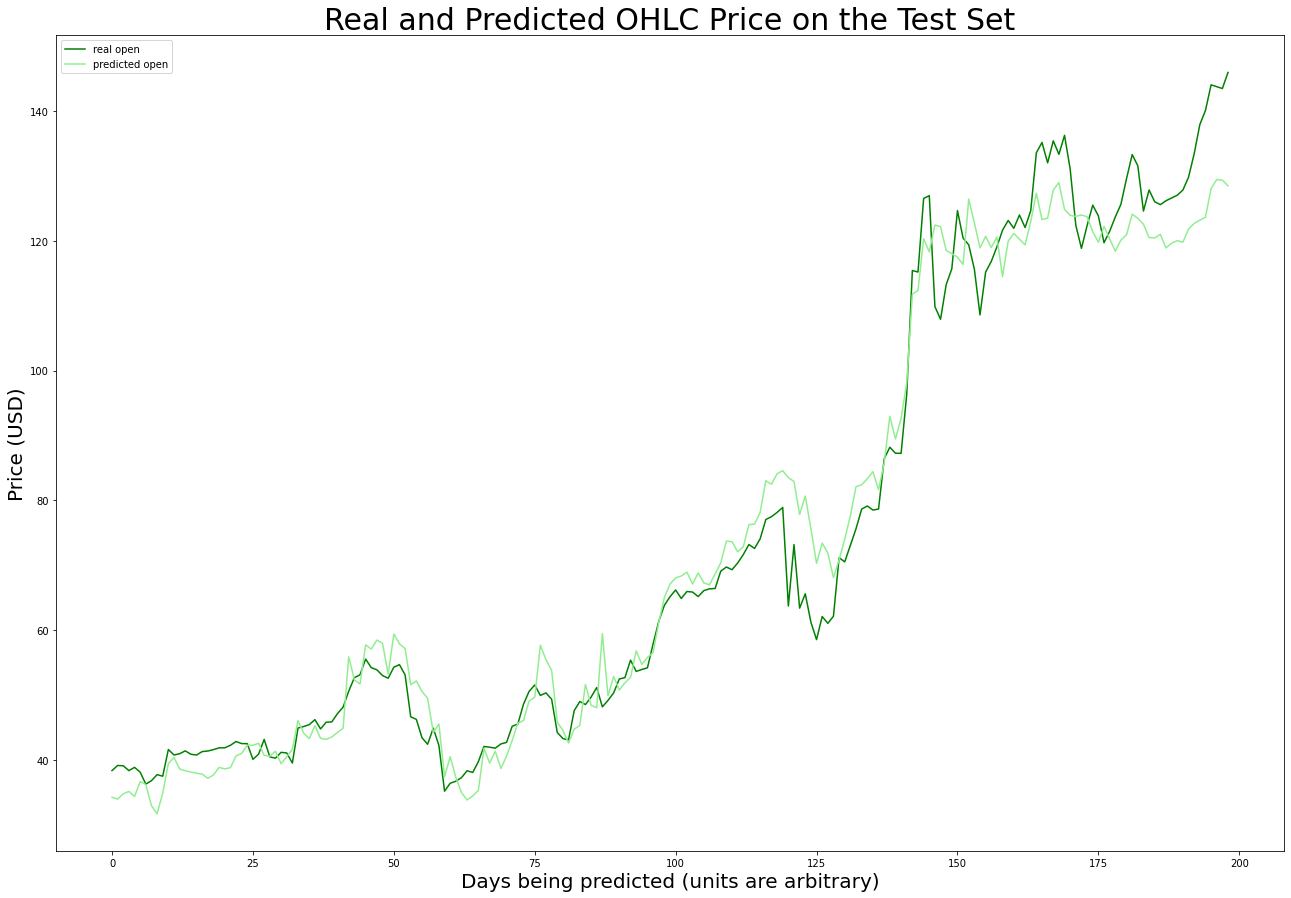

The MAE is:  4.563923801389462
The MSE is:  36.26078565450507


In [ ]:
y_test_open_pred, y_test_high_pred, y_test_low_pred, y_test_close_pred = model.predict(X_test)
# display(model.predict(X_test))
# display(y_test_open_pred.shape, y_test_high_pred.shape, y_test_low_pred.shape, y_test_close_pred.shape)
preds_arr = np.hstack((y_test_open_pred, y_test_high_pred, y_test_low_pred, y_test_close_pred))
# df_preds = pd.DataFrame(data=)
# display(df_preds)
y_test_pred = y_normaliser.inverse_transform(preds_arr)

# display(y_test_pred.shape, unscaled_y_test.shape)

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

# real values plotted
real_open = plt.plot(unscaled_y_test[:,start], label='real open', color='green')
# real_high = plt.plot(unscaled_y_test[:,start + 1], label='real high', color='blue')
# real_low = plt.plot(unscaled_y_test[:,start + 2], label='real low', color='orange')
# real_close = plt.plot(unscaled_y_test[:,start + 3], label='real close', color='red')

# predicted values plotted
pred_open = plt.plot(y_test_pred[:,start], label='predicted open', color='lightgreen')
# pred_high = plt.plot(y_test_pred[:,start + 1], label='predicted high', color='lightblue')
# pred_low = plt.plot(y_test_pred[:,start + 2], label='predicted low', color='moccasin')
# pred_close = plt.plot(y_test_pred[:,start + 3], label='predicted close', color='lightcoral')

# diff_1 = plt.plot(unscaled_y_test[:,start] - y_test_pred[:,start], label='open diff', color='yellow')

plt.legend()
plt.xlabel('Days being predicted (units are arbitrary)', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted OHLC Price on the Test Set', fontsize=30)

plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(unscaled_y_test, y_test_pred)
mse = mean_squared_error(unscaled_y_test, y_test_pred)

print("The MAE is: ", mae)
print("The MSE is: ", mse)



In [ ]:
def percentage(a,b):
    s=0
    m=0
    for i in range(len(a)):
        if(b.iloc[i]>0):
            m+=1
            s+=(abs(a[i]-b.iloc[i])/b.iloc[i])
    return 100*s/m

In [ ]:
df_real = pd.DataFrame(data=unscaled_y_test)
df_pred = pd.DataFrame(data=y_test_pred)
display(df_real, df_real[[0]], df_pred[[0]])

,0,1,2,3
0,38.354657,38.400055,37.714297,37.719076
1,39.138380,39.159885,38.854041,39.030857
2,39.100150,39.310417,39.061919,39.186168
3,38.349878,38.720235,38.204124,38.588818
4,38.854041,39.176610,37.936512,38.435896
...,...,...,...,...
194,140.070000,143.150000,140.070000,142.020000
195,144.030000,147.460000,143.630000,145.640000
196,143.750000,144.070000,141.670000,142.450000
197,143.460000,147.099700,142.960000,146.150000


,0
0,38.354657
1,39.138380
2,39.100150
3,38.349878
4,38.854041
...,...
194,140.070000
195,144.030000
196,143.750000
197,143.460000


,0
0,34.244240
1,33.966084
2,34.777466
3,35.140350
4,34.368481
...,...
194,123.617607
195,128.036926
196,129.438843
197,129.336929


In [ ]:
percentage(df_real[0], df_pred[0])

6.144593790419019

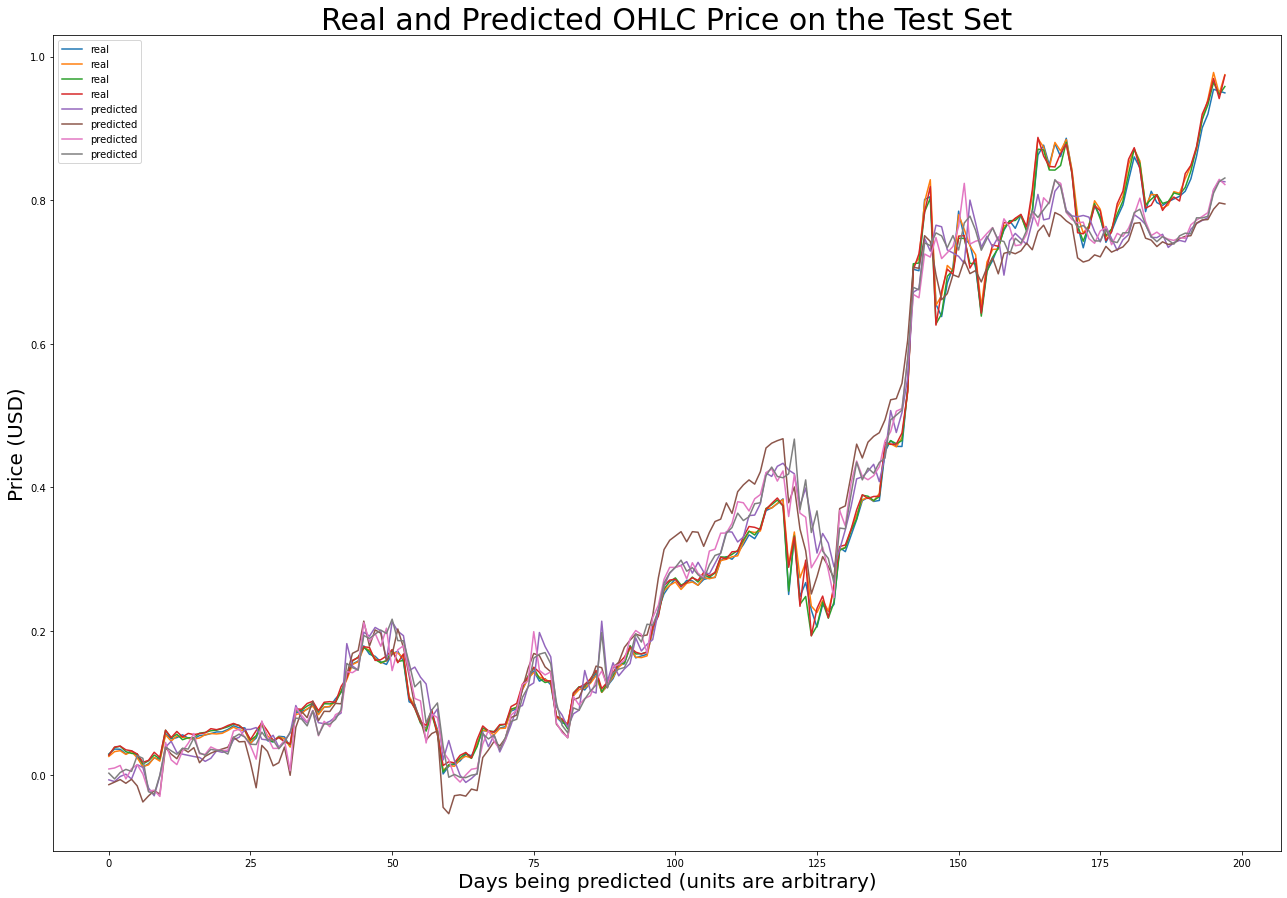

The MAE is:  0.03998808207545234
The MSE is:  0.0027824266434731846


In [ ]:
# Debugging to fix predictions. More specifically, checking if the normalization is the issue.
# Normalization is NOT the issue

y_test_open_pred, y_test_high_pred, y_test_low_pred, y_test_close_pred = model.predict(X_test)
preds_arr = np.hstack((y_test_open_pred, y_test_high_pred, y_test_low_pred, y_test_close_pred))
y_test_pred = preds_arr

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test[start:end], label='real')
pred = plt.plot(y_test_pred[start:end], label='predicted')

plt.legend()
plt.xlabel('Days being predicted (units are arbitrary)', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted OHLC Price on the Test Set', fontsize=30)

plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

print("The MAE is: ", mae)
print("The MSE is: ", mse)

